In [277]:
# Импорт библиотек
import pandas as pd
import torch

from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [278]:
# Загрузка датасета
mnist_train = pd.read_csv('fmnist_train.csv')
mnist_test = pd.read_csv('fmnist_test.csv')
submission = pd.read_csv('sample_submission.csv')

In [279]:
mnist_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,Id
0,2,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,9,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,6,0,0,0,0,0,0,0,5,0,...,0.0,0.0,30.0,43.0,0.0,0.0,0.0,0.0,0.0,2
3,0,0,0,0,1,2,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3
4,3,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [280]:
mnist_test.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,Id
0,0,0,0,0,0,0,0,9,8,0,...,87,56,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,14,53,99,17,...,0,0,0,63,53,31,0,0,0,2
3,0,0,0,0,0,0,0,0,0,161,...,126,140,0,133,224,222,56,0,0,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [281]:
submission.head() # анализ итогового сабмишена

,Id,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [282]:
a = mnist_train.isna().sum(axis=0)
a[a > 0].count()

424

В трейне в 424 столбцах есть хотя бы 1 НаН.

In [283]:
a = mnist_test.isna().sum(axis=0)
a[a > 0].count()

0

В тесте пропусков нет.

In [284]:
# Поскольку здесь признаки - пиксели, и пропусков мало, мы их дропнем
mnist_train.dropna(axis=0, inplace=True)
a = mnist_train.isna().sum(axis=0)
a[a > 0].count()

0

In [285]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Доступно: {device}")

Доступно: cuda:0


In [286]:
# Отбираем нужные признаки, переводим в тензоры и кидаем на девайс
X_train = mnist_train.iloc[:, 1:-1].values
y_train = mnist_train.iloc[:, 0].values
X_test = mnist_test.iloc[:, :-1].values

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

In [287]:
X_train.shape, X_test.shape # Проверка размерности

(torch.Size([17039, 784]), torch.Size([10000, 784]))

In [288]:
# Создали модель
def create_model(inputs, labels, device):
    model = torch.nn.Sequential(
        torch.nn.Linear(inputs, inputs * 3),
        torch.nn.ReLU(),
        torch.nn.Linear(inputs * 3, labels)
    )
    model = model.to(device)
    return model

# Обучение модели
def train_model(model, opt, X_train, y_train, epochs, device):
    criterion = torch.nn.CrossEntropyLoss()
    loss_train = []

    for epoch in tqdm(range(epochs)):
        model.train()
        opt.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss_train.append(loss.detach().cpu().numpy())
        loss.backward()
        opt.step()

    return loss_train

100%|██████████| 500/500 [00:08<00:00, 57.74it/s]


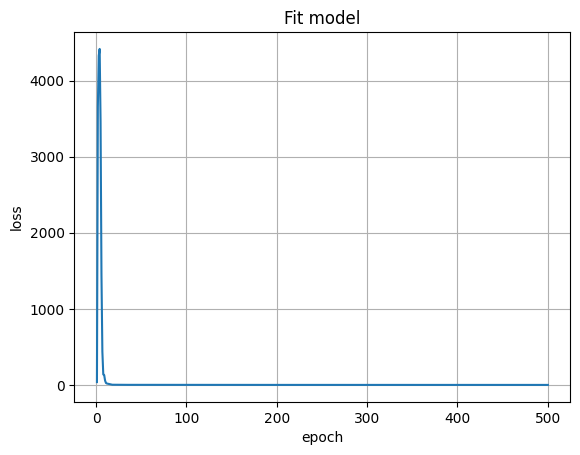

In [289]:
model = create_model(X_train.shape[1],len(y_train.unique()),device)
opt = torch.optim.Adam(model.parameters(), lr=0.01)
loss_train = train_model(model, opt, X_train, y_train, 500, device)

plt.plot(range(1, len(loss_train)+1), loss_train)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Fit model')
plt.grid(True)
plt.show()

In [290]:
# Делаем прелсказание и загружаем в сабмишн
model.eval()
with torch.no_grad():
    output = model(X_test)
    y_pred = torch.argmax(output, dim=1).detach().cpu().numpy()
submission["label"] = y_pred
submission.to_csv('submission.csv', index=False)